In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from lmfit import Model, Parameter, report_fit
from scipy.optimize import curve_fit
from copy import copy
from utils.physics import *
import icecream as ic

In [2]:
file = uproot.open(
    "~/Dropbox (MIT)/data/dvcs_inb.root")

In [3]:
M = 0.938272081
me = 0.5109989461 * 0.001
ebeam = 10.604
pbeam = np.sqrt(ebeam * ebeam - me * me)
beam = [0, 0, pbeam]
target = [0, 0, 0]

In [4]:
tree = file["T"]

In [5]:
# initialize df
df_electron = pd.DataFrame()
df_proton = pd.DataFrame()
df_gamma = pd.DataFrame()

In [6]:
for key in ["Epx", "Epy", "Epz", "Evz", "Esector"]:
    df_electron[key] = tree[key].array(library="pd")

In [7]:
# %matplotlib
# fig, ax = plt.subplots()
# cmap = copy(plt.cm.get_cmap("jet"))
# # ax.hist(180/np.pi*np.arctan(np.sqrt(df_electron["Epx"]**2+df_electron["Epy"])/df_electron["Epz"]), bins = 51)
# # ax.hist2d(180/np.pi*np.arctan2(df_electron["Epy"], df_electron["Epx"]), 180/np.pi*np.arctan(np.sqrt(df_electron["Epx"]**2+df_electron["Epy"]**2)/df_electron["Epz"]), bins = [51, 51], cmin = 1, cmap = cmap)
# ax.hist2d(180/np.pi*np.arctan2(df_proton["Ppy"], df_proton["Ppx"]), 180/np.pi*np.arctan(np.sqrt(df_proton["Ppx"]**2+df_proton["Ppy"]**2)/df_proton["Ppz"]), bins = [360, 360], cmin = 1, cmap = cmap)
# # ax.hist2d(180/np.pi*np.arctan2(df_electron["Epy"], df_electron["Epx"]), 180/np.pi*np.arctan(np.sqrt(df_electron["Epx"]**2+df_electron["Epy"]**2)/df_electron["Epz"]), bins = [51, 51])
# plt.show()

In [8]:
for key in ["Ppx", "Ppy", "Ppz", "Pvz", "Pstat", "PorigIndx", "Psector"]:
    df_proton[key] = tree[key].array(library="pd")

In [9]:
for key in ["Gpx", "Gpy", "Gpz", "Gstat", "GorigIndx", "Gsector"]:
    df_gamma[key] = tree[key].array(library="pd")

In [10]:
# change the data type to double
df_electron = df_electron.astype({"Epx": float, "Epy": float, "Epz": float})
df_proton = df_proton.astype({"Ppx": float, "Ppy": float, "Ppz": float})
df_gamma = df_gamma.astype({"Gpx": float, "Gpy": float, "Gpz": float})

In [11]:
df_electron['event'] = df_electron.index.get_level_values('entry')
df_proton['event'] = df_proton.index.get_level_values('entry')
df_gamma['event'] = df_gamma.index.get_level_values('entry')

In [12]:
df_gg = pd.merge(df_gamma, df_gamma,
    how='outer', on='event', suffixes=("", "2"))
df_gg = df_gg[df_gg["GorigIndx"] < df_gg["GorigIndx2"]]

In [13]:
#Now new indexing, which conserves event number information at "event" column
df_ep = pd.merge(df_electron, df_proton, how='outer', on='event')
df_epg = pd.merge(df_ep, df_gamma, how='outer', on='event')
df_epgg = pd.merge(df_ep, df_gg, how='outer', on='event')
df_epgg = df_epgg[~np.isnan(df_epgg["Gpx"])]

In [14]:
df_epg=df_epg[np.abs(df_epg["Evz"]-df_epg["Pvz"])<2.5+2.5/mag([df_epg["Epx"],df_epg["Epy"],df_epg["Epz"]])]
df_epgg=df_epgg[np.abs(df_epgg["Evz"]-df_epgg["Pvz"])<2.5+2.5/mag([df_epgg["Epx"],df_epgg["Epy"],df_epgg["Epz"]])]

In [15]:
# basic particle energies
df_epgg['Ee'] = np.sqrt(me**2 + df_epgg["Epx"]**2 + df_epgg["Epy"]**2 + df_epgg["Epz"]**2)
df_epgg['Pe'] = np.sqrt(M**2 + df_epgg["Ppx"]**2 + df_epgg["Ppy"]**2 + df_epgg["Ppz"]**2)
df_epgg['Ge'] = np.sqrt(df_epgg["Gpx"]**2 + df_epgg["Gpy"]**2 + df_epgg["Gpz"]**2)
df_epgg['Ge2'] = np.sqrt(df_epgg["Gpx2"]**2 + df_epgg["Gpy2"]**2 + df_epgg["Gpz2"]**2)

In [16]:
# useful objects
ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]
pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]
gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]
gam2 = [df_epgg['Gpx2'], df_epgg['Gpy2'], df_epgg['Gpz2']]
pi0 = vecAdd(gam, gam2)
VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
v3l = cross(beam, ele)
v3h = cross(pro, VGS)
v3g = cross(VGS, gam)
VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
            df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
Vmiss = [-df_epgg["Epx"] - df_epgg["Ppx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
            -df_epgg["Epy"] - df_epgg["Ppy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
            pbeam - df_epgg["Epz"] - df_epgg["Ppz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]
VmissP = [-df_epgg["Epx"] - df_epgg["Gpx"] - df_epgg["Gpx2"],
            -df_epgg["Epy"] - df_epgg["Gpy"] - df_epgg["Gpy2"],
            pbeam - df_epgg["Epz"] - df_epgg["Gpz"] - df_epgg["Gpz2"]]

In [17]:
# binning kinematics
df_epgg['Q2'] = -((ebeam - df_epgg['Ee'])**2 - mag2(VGS))
df_epgg['nu'] = (ebeam - df_epgg['Ee'])
df_epgg['xB'] = df_epgg['Q2'] / 2.0 / M / df_epgg['nu']
df_epgg['W'] = np.sqrt((ebeam + M - df_epgg['Ee'])**2 - mag2(VGS))
df_epgg['MPt'] = np.sqrt((df_epgg["Epx"] + df_epgg["Ppx"] + df_epgg["Gpx"] + df_epgg["Gpx2"])**2 +
                         (df_epgg["Epy"] + df_epgg["Ppy"] + df_epgg["Gpy"] + df_epgg["Gpy2"])**2)

In [18]:
# exclusivity variables
df_epgg['MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                     df_epgg["Pe"])**2 - mag2(VmissPi0)
df_epgg['MM2_egg'] = (-M - ebeam + df_epgg["Ee"] +
                     df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(VmissP)
df_epgg['MM2_epgg'] = (-M - ebeam + df_epgg["Ee"] +
                     df_epgg["Pe"] + df_epgg["Ge"] + df_epgg["Ge2"])**2 - mag2(Vmiss)
df_epgg['ME_epgg'] = (M + ebeam - df_epgg["Ee"] - df_epgg["Pe"] - df_epgg["Ge"] - df_epgg["Ge2"])
df_epgg['Mpi0'] = pi0InvMass(gam, gam2)
df_epgg['reconPi'] = angle(VmissPi0, pi0)
df_epgg["Pie"] = df_epgg['Ge'] + df_epgg['Ge2']
df_epgg["sintheta"] = np.sin(np.pi/180.*angle(gam, gam2))

In [19]:
#	Kinematic cuts
#   xB>0 && xB<1 && W>2 && Q2>1 && VE.e()>2 && VG1.e() > 2 && VP.p() > 0.12
cut_pFD = df_epgg["Pstat"] < 4000  # FD
cut_pCD = df_epgg["Pstat"] > 4000  # CD
cut_gFD = df_epgg["Gstat"] > 2000  # FD
cut_gFT = df_epgg["Gstat"] < 2000  # FT
cut_g2FD = df_epgg["Gstat2"] > 2000  # FD
cut_g2FT = df_epgg["Gstat2"] < 2000  # FT
cut_FTFT = cut_gFT & cut_g2FT
cut_FDFT = cut_gFD & cut_g2FT
cut_FTFD = cut_gFT & cut_g2FD
cut_FDFD = cut_gFD & cut_g2FD
cut_xBupper = df_epgg["xB"] < 1  # xB
cut_xBlower = df_epgg["xB"] > 0  # xB
cut_Q2 = df_epgg["Q2"] > 1  # Q2
cut_W = df_epgg["W"] > 2  # W

In [20]:
#	Exclusivity cuts
cut_mmep = df_epgg["MM2_ep"] < 0.7  # mmep
cut_meepgg = df_epgg["ME_epgg"] < 0.7  # meepgg
cut_mpt = df_epgg["MPt"] < 0.2  # mpt
cut_recon = df_epgg["reconPi"] < 2  # recon gam angle
cut_pi0upper = df_epgg["Mpi0"] < 0.2
cut_pi0lower = df_epgg["Mpi0"] > 0.07
cut_pi0energy = 1#(df_epgg["Pie"] > 2) & (df_epgg["Pie"] <4)
# cut_maxE = 1#df_epgg[["Ge", "Ge2"]].max(1) > 2
cut_minE = 1#df_epgg[["Ge", "Ge2"]].min(1) > 1
cut_sector = (df_epgg["Esector"]!=df_epgg["Gsector"]) & (df_epgg["Esector"]!=df_epgg["Gsector2"])

In [21]:
df_dvpi0 = df_epgg[cut_sector & cut_xBupper & cut_xBlower & cut_Q2 & cut_W & cut_mmep & cut_meepgg &
                   cut_mpt & cut_recon & cut_pi0upper & cut_pi0lower & cut_minE & cut_pi0energy]
# df_dvpi0.loc[:, "Mpi0"] = df_dvpi0["Mpi0"]/0.1349768
print(len(df_dvpi0))
mpi0_edges = np.linspace(0.5, 1.5, 101)
# df_dvpi0.loc[:,"Mpi0"]

189887


In [113]:
%matplotlib
fig, ax = plt.subplots()
cmap = copy(plt.cm.get_cmap("jet"))
df_sym = df_dvpi0
print(len(df_sym))
print(((0.1349768/df_sym["Mpi0"])).mean())
# ax.hist2d(df_sym["Ge"], (0.1349768/df_sym["Mpi0"])**2-1, bins = [51, 51], cmap = cmap, cmin = 1)
ax.hist(df_sym["Mpi0"]/0.1349768, bins = np.linspace(0.8, 1.2, 51))
# plt.xlim([-0.5, 1.2])
# ax.hist2d(df_sym["Ge2"], (df_sym["Mpi0"]/0.1349768), bins = [51, 51], cmap = cmap, cmin = 1)
# plt.xlabel("ME_epgg")
# plt.ylabel("reconstructed pi0 mass")
# ax.hist(df_dvpi0["Mpi0"], bins = 101)
plt.show()


Using matplotlib backend: MacOSX
92717
1.025109847173281


In [96]:
df_corr = df_epgg

In [97]:
cut_gFD = df_corr["Gstat"] > 2000  # FD
cut_gFT = df_corr["Gstat"] < 2000  # FT
cut_g2FD = df_corr["Gstat2"] > 2000  # FD
cut_g2FT = df_corr["Gstat2"] < 2000  # FT

In [98]:
df_corr["Ge"] = np.where(cut_gFD, 0.25 + df_corr["Ge"], df_corr["Ge"])
df_corr["Gpx"] = np.where(cut_gFD, df_corr["Ge"]/(df_corr["Ge"]-0.25)*df_corr["Gpx"], df_corr["Gpx"])
df_corr["Gpy"] = np.where(cut_gFD, df_corr["Ge"]/(df_corr["Ge"]-0.25)*df_corr["Gpy"], df_corr["Gpy"])
df_corr["Gpz"] = np.where(cut_gFD, df_corr["Ge"]/(df_corr["Ge"]-0.25)*df_corr["Gpz"], df_corr["Gpz"])
# df_corr["Ge2"] = np.where(cut_g2FD, 0.25 + df_corr["Ge2"], df_corr["Ge2"])
# df_corr["Gpx2"] = np.where(cut_g2FD, df_corr["Ge2"]/(df_corr["Ge2"]-0.25)*df_corr["Gpx2"], df_corr["Gpx2"])
# df_corr["Gpy2"] = np.where(cut_g2FD, df_corr["Ge2"]/(df_corr["Ge2"]-0.25)*df_corr["Gpy2"], df_corr["Gpy2"])
# df_corr["Gpz2"] = np.where(cut_g2FD, df_corr["Ge2"]/(df_corr["Ge2"]-0.25)*df_corr["Gpz2"], df_corr["Gpz2"])

In [99]:
# useful objects
ele = [df_corr['Epx'], df_corr['Epy'], df_corr['Epz']]
pro = [df_corr['Ppx'], df_corr['Ppy'], df_corr['Ppz']]
gam = [df_corr['Gpx'], df_corr['Gpy'], df_corr['Gpz']]
gam2 = [df_corr['Gpx2'], df_corr['Gpy2'], df_corr['Gpz2']]
pi0 = vecAdd(gam, gam2)
VGS = [-df_corr['Epx'], -df_corr['Epy'], pbeam - df_corr['Epz']]
v3l = cross(beam, ele)
v3h = cross(pro, VGS)
v3g = cross(VGS, gam)
VmissPi0 = [-df_corr["Epx"] - df_corr["Ppx"], -df_corr["Epy"] -
            df_corr["Ppy"], pbeam - df_corr["Epz"] - df_corr["Ppz"]]
Vmiss = [-df_corr["Epx"] - df_corr["Ppx"] - df_corr["Gpx"] - df_corr["Gpx2"],
            -df_corr["Epy"] - df_corr["Ppy"] - df_corr["Gpy"] - df_corr["Gpy2"],
            pbeam - df_corr["Epz"] - df_corr["Ppz"] - df_corr["Gpz"] - df_corr["Gpz2"]]

In [100]:
# exclusivity variables
df_corr['MM2_ep'] = (-M - ebeam + df_corr["Ee"] +
                     df_corr["Pe"])**2 - mag2(VmissPi0)
df_corr['MM2_epgg'] = (-M - ebeam + df_corr["Ee"] +
                     df_corr["Pe"] + df_corr["Ge"] + df_corr["Ge2"])**2 - mag2(Vmiss)
df_corr['ME_epgg'] = (M + ebeam - df_corr["Ee"] - df_corr["Pe"] - df_corr["Ge"] - df_corr["Ge2"])
df_corr['Mpi0'] = pi0InvMass(gam, gam2)
df_corr['reconPi'] = angle(VmissPi0, pi0)
df_corr["Pie"] = df_corr['Ge'] + df_corr['Ge2']
df_corr["sintheta"] = np.sin(np.pi/180.*angle(gam, gam2))

In [101]:
#	Kinematic cuts
#   xB>0 && xB<1 && W>2 && Q2>1 && VE.e()>2 && VG1.e() > 2 && VP.p() > 0.12
cut_pFD = df_corr["Pstat"] < 4000  # FD
cut_pCD = df_corr["Pstat"] > 4000  # CD
cut_gFD = df_corr["Gstat"] > 2000  # FD
cut_gFT = df_corr["Gstat"] < 2000  # FT
cut_g2FD = df_corr["Gstat2"] > 2000  # FD
cut_g2FT = df_corr["Gstat2"] < 2000  # FT
cut_FTFT = cut_gFT & cut_g2FT
cut_FDFT = cut_gFD & cut_g2FT
cut_FTFD = cut_gFT & cut_g2FD
cut_FDFD = cut_gFD & cut_g2FD
cut_xBupper = df_corr["xB"] < 1  # xB
cut_xBlower = df_corr["xB"] > 0  # xB
cut_Q2 = df_corr["Q2"] > 1  # Q2
cut_W = df_corr["W"] > 2  # W

In [102]:
#	Exclusivity cuts
cut_mmep = df_corr["MM2_ep"] < 0.7  # mmep
cut_meepgg = df_corr["ME_epgg"] < 0.7  # meepgg
cut_mpt = df_corr["MPt"] < 0.2  # mpt
cut_recon = df_corr["reconPi"] < 2  # recon gam angle
cut_pi0upper = df_corr["Mpi0"] < 0.2
cut_pi0lower = df_corr["Mpi0"] > 0.07
cut_pi0energy = 1#(df_corr["Pie"] > 2) & (df_corr["Pie"] <4)
# cut_maxE = 1#df_corr[["Ge", "Ge2"]].max(1) > 2
cut_minE = 1#df_corr[["Ge", "Ge2"]].min(1) > 1
cut_sector = (df_corr["Esector"]!=df_corr["Gsector"]) & (df_corr["Esector"]!=df_corr["Gsector2"])

In [103]:
df_dvpi0corr = df_corr[cut_sector & cut_pFD & cut_FDFD & cut_xBupper & cut_xBlower & cut_Q2 & cut_W & cut_mmep & cut_meepgg &
                   cut_mpt & cut_recon & cut_pi0upper & cut_pi0lower & cut_pi0energy]
# df_dvpi0.loc[:, "Mpi0"] = df_dvpi0["Mpi0"]/0.1349768
print(len(df_dvpi0corr))
mpi0_edges = np.linspace(0.5, 1.5, 101)
# df_dvpi0.loc[:,"Mpi0"]

120694


In [116]:
%matplotlib
fig, ax = plt.subplots()
cmap = copy(plt.cm.get_cmap("jet"))
df_sym = df_dvpi0corr[df_dvpi0corr['Ge2']>0.5]#[np.abs(df_dvpi0corr["Ge2"]-df_dvpi0corr["Ge"])<2]
ax.hist(df_sym["Mpi0"]/0.1349768, bins = np.linspace(0.8, 1.2, 51))

# print(len(df_sym))
# print((0.1349768/df_sym["Mpi0"]).mean())
# # ax.hist2d(df_sym["Ge"], (0.1349768/df_sym["Mpi0"])**2-1, bins = [51, 51], cmap = cmap, cmin = 1)
# ax.hist2d(df_sym["Ge2"], df_sym["Mpi0"]/0.1349768, bins = [51, 51], cmap = cmap, cmin = 1)
# plt.xlabel("Ge")
# plt.ylabel("reconstructed pi0 mass")
# ax.hist(df_dvpi0["Mpi0"], bins = 101)
plt.show()


Using matplotlib backend: MacOSX


In [22]:
beam = [0, 0, pbeam]
target = [0, 0, 0]
ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

In [23]:
#energy
df_epg['Ee'] = np.sqrt(me**2+df_epg["Epx"]**2+df_epg["Epy"]**2+df_epg["Epz"]**2)
df_epg['Pe'] = np.sqrt(M**2+df_epg["Ppx"]**2+df_epg["Ppy"]**2+df_epg["Ppz"]**2)
df_epg['Ge'] = np.sqrt(df_epg["Gpx"]**2+df_epg["Gpy"]**2+df_epg["Gpz"]**2)

In [24]:
#binning kinematics
df_epg['Q2'] = -((ebeam-df_epg['Ee'])**2-df_epg['Epx']**2-df_epg['Epy']**2-(pbeam-df_epg['Epz'])**2)
df_epg['xB'] = df_epg['Q2']/2.0/M/(ebeam-df_epg['Ee'])
df_epg['nu'] = (ebeam-df_epg['Ee'])
VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
df_epg['t1'] = 2*M*(df_epg['Pe']-M)
costheta = cosTheta(VGS, gam)
df_epg['t2'] = (M*df_epg['Q2']+2*M*df_epg['nu']*(df_epg['nu']-np.sqrt(df_epg['nu']*df_epg['nu']+df_epg['Q2'])*costheta))/(M+df_epg['nu']-np.sqrt(df_epg['nu']*df_epg['nu']+df_epg['Q2'])*costheta)
df_epg['W'] = np.sqrt((ebeam+M-df_epg['Ee'])**2-df_epg['Epx']**2-df_epg['Epy']**2-(pbeam-df_epg['Epz'])**2)

In [25]:
v3l = cross(beam, ele)
v3h = cross(pro, VGS)
v3g = cross(VGS, gam)

In [26]:
df_epg['phi1'] = angle(v3l, v3h)
df_epg['phi1'] = np.where(dot(v3l, pro)>0, 360.0 - df_epg['phi1'], df_epg['phi1'])

In [27]:
df_epg['phi2'] = angle(v3l, v3g)
df_epg['phi2'] = np.where(dot(VGS, cross(v3l, v3g))<0, 360.0 - df_epg['phi2'], df_epg['phi2'])

In [28]:
#exclusivity variables
df_epg['MM2_epg'] = (-M-ebeam+df_epg["Ee"]+df_epg["Pe"]+df_epg["Ge"])**2 - (df_epg["Epx"]+df_epg["Ppx"]+df_epg["Gpx"])**2 - \
(df_epg["Epy"]+df_epg["Ppy"]+df_epg["Gpy"])**2 -(-pbeam+df_epg["Epz"]+df_epg["Ppz"]+df_epg["Gpz"]) **2
df_epg['ME_epg'] = (M+ebeam-df_epg["Ee"]-df_epg["Pe"]-df_epg["Ge"])
df_epg['MM2_ep'] = (-M-ebeam+df_epg["Ee"]+df_epg["Pe"])**2 - (df_epg["Epx"]+df_epg["Ppx"])**2 - \
(df_epg["Epy"]+df_epg["Ppy"])**2 -(-pbeam+df_epg["Epz"]+df_epg["Ppz"]) **2
df_epg['MM2_eg'] = (-M-ebeam+df_epg["Ee"]+df_epg["Ge"])**2 - (df_epg["Epx"]+df_epg["Gpx"])**2 - \
(df_epg["Epy"]+df_epg["Gpy"])**2 -(-pbeam+df_epg["Epz"]+df_epg["Gpz"]) **2
df_epg['MPt'] = np.sqrt((df_epg["Epx"]+df_epg["Ppx"]+df_epg["Gpx"])**2 + \
(df_epg["Epy"]+df_epg["Ppy"]+df_epg["Gpy"])**2)
df_epg['coneAngle'] = angle(ele, gam)#180.*/np.pi*np.arccos((df_epg["Epx"]*df_epg["Gpx"]+df_epg["Epy"]*df_epg["Gpy"]+df_epg["Epz"]*df_epg["Gpz"])/np.sqrt(df_epg["Epx"]*df_epg["Epx"]+df_epg["Epy"]*df_epg["Epy"]+df_epg["Epz"]*df_epg["Epz"])/np.sqrt(df_epg["Gpx"]*df_epg["Gpx"]+df_epg["Gpy"]*df_epg["Gpy"]+df_epg["Gpz"]*df_epg["Gpz"]))
VmissG = [-df_epg["Epx"]-df_epg["Ppx"], -df_epg["Epy"]-df_epg["Ppy"], pbeam-df_epg["Epz"]-df_epg["Ppz"]]
df_epg['reconGam'] = angle(gam, VmissG)
Vhadr = cross(pro, VGS)
Vhad2 = cross(VGS, gam)
df_epg['coplanarity'] = angle(Vhadr, Vhad2)

In [28]:
# df_epg["xB"][0:5]
# df_epg["Q2"][0:5]
# df_epg["W"][0:5]
# df_epg["Ee"][0:5]
# df_epg["Ge"][0:5]
# np.sqrt(dot([df_epg["Ppx"],df_epg["Ppy"],df_epg["Ppz"]],[df_epg["Ppx"],df_epg["Ppy"],df_epg["Ppz"]]))[0:5]
# df_epg["coneAngle"][0:5]*np.pi/180
# df_epg["reconGam"][0:5]*np.pi/180
# df_epg["MPt"][0:5]
# np.abs(df_epg["MM2_epg"])[0:5]
# df_epg["ME_epg"][0:5]
# np.sqrt(df_epg["MM2_eg"])[0:5]


In [29]:
df_epg=df_epg[df_epg["MM2_eg"]>0]

In [30]:
#cuts
#Kinematics
#      xB>0 && xB<1 && W>2 && Q2>1 && VE.e()>2 && VG1.e() > 2 && VP.p() > 0.12
cut_forward = df_epg["Pstat"]<4000
cut_central = df_epg["Pstat"]>4000
cut_xBupper = df_epg["xB"]<1
cut_xBlower = df_epg["xB"]>0
cut_Q2 = df_epg["Q2"]>1
cut_W = df_epg["W"]>2
cut_Ee = df_epg["Ee"]>2
cut_Ge = df_epg["Ge"]>2
cut_Pp = np.sqrt(dot([df_epg["Ppx"],df_epg["Ppy"],df_epg["Ppz"]],[df_epg["Ppx"],df_epg["Ppy"],df_epg["Ppz"]]))>0.12

In [31]:
#Exclusive
#mmepg
cut_mmepg = np.abs(df_epg["MM2_epg"])<0.04
# #mmeg
cut_mmegupper = np.sqrt(df_epg["MM2_eg"])<1.7
cut_mmeglower = np.sqrt(df_epg["MM2_eg"])>0.1
#meepg
cut_meepgupper = df_epg["ME_epg"]<1.2
cut_meepglower = df_epg["ME_epg"]>-0.5
#mpt
cut_mpt = df_epg["MPt"]<0.12
#coneangle
cut_cone = df_epg["coneAngle"]>10
#recon gam angle
cut_recon = df_epg["reconGam"]<1.1
#cut on coplanarity
#cut on mmep

In [44]:
df_dvcs = df_epg[cut_xBupper & cut_xBlower & cut_Q2 & cut_W & cut_Ee & cut_Ge & cut_Pp & cut_mmepg &
                 cut_mmegupper & cut_mmeglower & cut_meepgupper & cut_meepglower & cut_mpt & cut_cone & cut_recon]


In [45]:
pi0to2gammas = df_dvcs["event"].isin(df_dvpi0["event"])
df_dvcs = df_dvcs[~pi0to2gammas]

In [46]:
len(df_dvcs)

605011

In [47]:
df_dvcs = df_dvcs[df_dvcs["Esector"]!=df_dvcs["Gsector"]]

In [48]:
len(df_dvcs)

604926

array([[<AxesSubplot:title={'center':'xB'}>]], dtype=object)

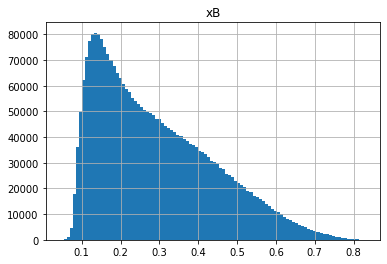

In [35]:
df_epg.hist(column="xB", bins=100)

In [36]:
df_dvcsForward = df_epg[cut_forward&cut_xBupper&cut_xBlower&cut_Q2&cut_W&cut_Ee&cut_Ge&cut_Pp &cut_mmepg & cut_mmegupper & cut_mmeglower & cut_meepgupper & cut_meepglower & cut_mpt & cut_cone & cut_recon]
df_dvcsCentral = df_epg[cut_central&cut_xBupper&cut_xBlower&cut_Q2&cut_W&cut_Ee&cut_Ge&cut_Pp &cut_mmepg & cut_mmegupper & cut_mmeglower & cut_meepgupper & cut_meepglower & cut_mpt & cut_cone & cut_recon]

In [76]:
len(df_dvcsForward["event"])

50695

In [91]:
%matplotlib
fig, ax = plt.subplots()
cmap = copy(plt.cm.get_cmap("jet"))
# df_sym = df_dvpi0corr[df_dvpi0corr['Ge2']>0.5]#[np.abs(df_dvpi0corr["Ge2"]-df_dvpi0corr["Ge"])<2]
ax.hist(df_dvcsCentral["ME_epg"], bins = np.linspace(-0.5, 1.2, 51))
plt.xlim([-0.5,1.2])
# print(len(df_sym))
# print((0.1349768/df_sym["Mpi0"]).mean())
# ax.hist2d(df_sym["Ge"], (0.1349768/df_sym["Mpi0"])**2-1, bins = [51, 51], cmap = cmap, cmin = 1)
# ax.hist2d(df_sym["Ge"], df_sym["Mpi0"]/0.1349768, bins = [51, 51], cmap = cmap, cmin = 1)
# plt.xlabel("Ge")
# plt.ylabel("reconstructed pi0 mass")
# ax.hist(df_dvpi0["Mpi0"], bins = 101)
plt.show()


Using matplotlib backend: MacOSX


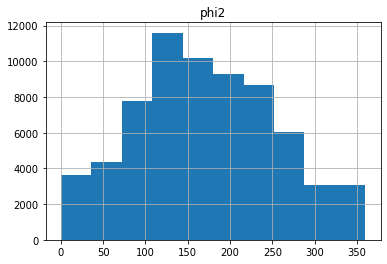

In [79]:
df_dvcsForward

,Epx,Epy,Epz,event,Ppx,Ppy,Ppz,Pstat,Gstat,Gpx,...,phi1,phi2,MM2_epg,ME_epg,MM2_ep,MM2_eg,MPt,coneAngle,reconGam,coplanarity
18,-0.753784,0.887033,4.895566,12,-0.498582,0.317820,2.075934,2230,2020.0,1.241927,...,190.190226,187.552565,0.021802,0.164891,1.058086,1.437631,0.050927,39.625663,0.919102,2.637660
133,0.630373,-1.164193,4.717692,77,-0.318428,0.045866,0.447476,2100,2030.0,-0.247556,...,70.976801,81.601318,-0.012180,0.400820,-0.080846,1.330556,0.067136,28.046861,0.849575,10.624516
358,-1.442151,0.015347,4.878903,235,0.345545,0.148999,0.490779,2100,2030.0,1.062705,...,35.562581,34.834999,-0.006519,0.155198,-0.209774,1.034236,0.035523,28.388482,0.062010,0.727582
373,1.179866,0.316151,3.063281,242,0.226473,0.048850,0.578634,2100,2030.0,-1.308641,...,177.960344,171.787249,0.004714,0.502373,0.083091,1.505993,0.113498,33.466623,0.279979,6.173095
482,0.583330,-1.116929,4.208818,313,0.108233,-0.102346,0.472765,2100,2030.0,-0.742113,...,191.940939,194.385743,-0.006062,0.072735,0.019072,0.928342,0.061703,30.690845,0.751400,2.444804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464377,-0.626680,-1.062343,7.392796,2308186,-0.305522,0.193244,0.635458,2100,2030.0,0.891792,...,121.060772,118.587324,-0.006352,0.163827,-0.093937,1.054350,0.083277,35.519827,0.547867,2.473448
3464406,-0.978643,1.057845,5.321038,2308206,0.518734,0.269983,0.869591,2100,2020.0,0.420550,...,98.107535,97.993810,-0.004542,0.211703,-0.082582,1.082798,0.059871,32.215699,0.331114,0.113726
3464552,1.696630,0.144941,5.080699,2308302,0.019879,0.318534,1.718582,2200,2030.0,-1.758154,...,209.788090,206.172024,-0.001640,-0.060969,-0.000717,0.832977,0.051605,43.564946,0.550774,3.616066
3464574,1.463205,0.076815,5.170465,2308319,-0.265448,-0.074670,0.478624,2100,2030.0,-1.112565,...,24.191706,28.858546,-0.014035,0.370142,-0.186338,1.262851,0.085701,29.486249,0.135622,4.666840


In [31]:
df_epg = df_epg[df_epg["MM2_eg"]>0]
df_epg = df_epg[cut_xBupper&cut_xBlower&cut_Q2&cut_W&cut_Ee&cut_Ge&cut_Pp]
df_epg = df_epg[cut_mmepg & cut_mmegupper & cut_mmeglower & cut_meepgupper & cut_meepglower & cut_mpt & cut_cone & cut_recon]

<ipython-input-31-447a48b8060f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_epg = df_epg[cut_xBupper&cut_xBlower&cut_Q2&cut_W&cut_Ee&cut_Ge&cut_Pp]
<ipython-input-31-447a48b8060f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_epg = df_epg[cut_mmepg & cut_mmegupper & cut_mmeglower & cut_meepgupper & cut_meepglower & cut_mpt & cut_cone & cut_recon]


In [35]:
df_epgForward = test2[test2["Pstat"]<4000]

In [44]:
df_epgForward["xB"]

18         0.276938
43         0.411142
133        0.361194
158        0.631960
358        0.427725
             ...   
3464406    0.425699
3464552    0.598666
3464574    0.440141
3464641    0.493923
3464648    0.437555
Name: xB, Length: 74275, dtype: float64

In [43]:
np.sqrt(dot([df_epg["Ppx"],df_epg["Ppy"],df_epg["Ppz"]],[df_epg["Ppx"],df_epg["Ppy"],df_epg["Ppz"]]))

10         0.432079
11         0.764697
13         0.349229
18         2.158494
28         1.129309
             ...   
3464641    1.299415
3464646    0.687101
3464647    0.970053
3464649    0.547467
3464666    0.384846
Length: 536817, dtype: float64